### Loading Cleaned Metadata files

In [1]:
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
from torchvision.transforms import ToTensor
from torch import nn, optim
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader

import cv2
from PIL import Image
from transformers import ViTModel, ViTImageProcessor, ViTForImageClassification
from timm import create_model

from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
print("Current Path : ", os.getcwd())
os.chdir("../..")

Current Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/src/04_models


In [13]:
ROOT_DIR = os.getcwd()
print("Root Project Path : ", ROOT_DIR)
ROOT_DATA_DIR = os.path.join(ROOT_DIR, "data", "xview_building_damage")
print("Root Data Path : ", ROOT_DATA_DIR)
TRAIN_DATA_DIR = os.path.join(ROOT_DATA_DIR, "train")
print("Train Data Path : ", TRAIN_DATA_DIR)
CHALLENGE_DIR = os.path.join(ROOT_DATA_DIR, "challenge")
TRAIN_DIR = os.path.join(CHALLENGE_DIR, "train")
HOLD_DIR = os.path.join(CHALLENGE_DIR, "hold")
TEST_DIR = os.path.join(CHALLENGE_DIR, "test")

Root Project Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio
Root Data Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage
Train Data Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/train


### Custom Dataset class

In [6]:
train_meta_df = pd.read_csv(
    os.path.join(
        ROOT_DATA_DIR,
        "challenge",
        "train",
        "disaster",
        "hc_train_hurricane-michael.csv",
    )
)
valid_meta_df = pd.read_csv(
    os.path.join(
        ROOT_DATA_DIR, "challenge", "hold", "disaster", "hc_hold_hurricane-michael.csv"
    )
)
test_meta_df = pd.read_csv(
    os.path.join(
        ROOT_DATA_DIR, "challenge", "test", "disaster", "hc_test_hurricane-michael.csv"
    )
)

In [ ]:
enumerate(train_loader)

In [ ]:
num_epochs = 1
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        if batch_idx >= 3:
            break
        print(" Batch index:", batch_idx, end="")
        print(" | Batch size:", y.shape[0], end="")
        print(" | x shape:", x.shape, end="")
        print(" | y shape:", y.shape)

print("Labels from current batch:", y)

### Setting the device

In [8]:
model_name = "vit_base_patch16_224"
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

print("device = ", device)

device =  mps


### Helper Methods

#### Data Augumentation:

In [11]:
# Write transform for image
data_transform = transforms.Compose(
    [
        # Resize the images to 64x64
        transforms.Resize(size=(224, 224)),
        # Flip the images randomly on the horizontal
        # transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
        # Turn the image into a torch.Tensor
        transforms.ToTensor(),  # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    ]
)

#### Load & Prepare Data

In [28]:
def get_img_class_dir(disaster_name, dataSplit, ROOT_DIR):
    DIR = os.path.join(ROOT_DIR, dataSplit, "disaster", disaster_name, "class", "post")
    return DIR

In [30]:
train_dataset = datasets.ImageFolder(
    get_img_class_dir("hurricane-michael", "train", CHALLENGE_DIR),
    transform=data_transform,
)
valid_dataset = datasets.ImageFolder(
    get_img_class_dir("hurricane-michael", "hold", CHALLENGE_DIR),
    transform=data_transform,
)
test_dataset = datasets.ImageFolder(
    get_img_class_dir("hurricane-michael", "test", CHALLENGE_DIR),
    transform=data_transform,
)
# dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
print("Train set records : ", len(train_dataset))
print("Validation set records : ", len(valid_dataset))
print("Test set records : ", len(test_dataset))
print("================================================")
print(f"Train data:\n{train_dataset}")
print(f"Validation data:\n{valid_dataset}")
print(f"Test data:\n{test_dataset}")

Train set records :  22686
Validation set records :  7158
Test set records :  5657
Train data:
Dataset ImageFolder
    Number of datapoints: 22686
    Root location: /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/train/disaster/hurricane-michael/class/post
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Validation data:
Dataset ImageFolder
    Number of datapoints: 7158
    Root location: /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/challenge/hold/disaster/hurricane-michael/class/post
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 5657
    Root location:

In [16]:
class_names = train_dataset.classes
class_names

['destroyed', 'major-damage', 'minor-damage', 'no-damage', 'un-classified']

In [17]:
class_dict = train_dataset.class_to_idx
class_dict

{'destroyed': 0,
 'major-damage': 1,
 'minor-damage': 2,
 'no-damage': 3,
 'un-classified': 4}

In [31]:
img, label = train_dataset[0][0], train_dataset[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Image shape: torch.Size([3, 224, 224])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


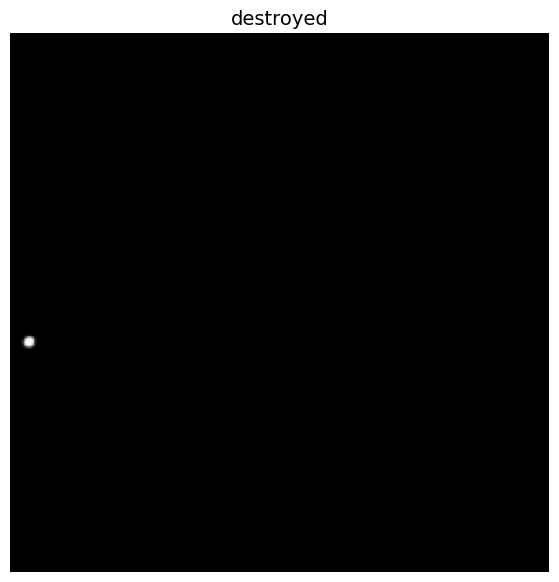

In [32]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

#### Spliting the train into train and validation

In [34]:
trainset = torch.utils.data.Subset(train_dataset, list(range(len(train_dataset))))
testset = torch.utils.data.Subset(test_dataset, list(range(len(test_dataset))))
validset = torch.utils.data.Subset(valid_dataset, list(range(len(valid_dataset))))

In [41]:
batch_size = 16

# percentage of training set to use as validation
valid_size = 0.2

# get training indices that wil be used for validation
# train_size = len(trainset)
# indices = list(range(train_size))
# np.random.shuffle(indices)
# split = int(np.floor(valid_size * train_size))
# train_idx, valid_idx = indices[split:], indices[:split]

# define samplers to obtain training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=2)
valid_loader = DataLoader(validset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=2)

#### Class Statistics - Class Balance

In [37]:
# print out classes statistics

# get all training samples labels
train_labels = [labels for i, (images, labels) in enumerate(train_loader)]
train_labels = torch.cat((train_labels), 0)
train_labels_count = train_labels.unique(return_counts=True)

# # print(train_labels_count)

print("The number of samples per classes in training dataset:\n")
for label, count in zip(train_labels_count[0], train_labels_count[1]):
    print("\t {}: {}".format(label, count))

The number of samples per classes in training dataset:

	 0: 757
	 1: 1902
	 2: 5207
	 3: 14588
	 4: 232


In [42]:
# get all test samples labels
valid_labels = [labels for i, (images, labels) in enumerate(valid_loader)]
valid_labels = torch.cat((valid_labels), 0)
valid_labels_count = valid_labels.unique(return_counts=True)

print("The number of samples per classes in valid dataset:\n")
for label, count in zip(valid_labels_count[0], valid_labels_count[1]):
    print("\t {}: {}".format(label, count))

The number of samples per classes in valid dataset:

	 0: 285
	 1: 608
	 2: 1722
	 3: 4457
	 4: 86


In [43]:
# get all test samples labels
test_labels = [labels for i, (images, labels) in enumerate(test_loader)]
test_labels = torch.cat((test_labels), 0)
test_labels_count = test_labels.unique(return_counts=True)

print()
print("The number of samples per classes in test dataset:\n")
for label, count in zip(test_labels_count[0], test_labels_count[1]):
    print("\t {}: {}".format(label, count))


The number of samples per classes in test dataset:

	 0: 183
	 1: 409
	 2: 1363
	 3: 3647
	 4: 55


In [ ]:
class_dict

### Model Training

In [44]:
vision_transformer = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
vision_transformer

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [45]:
# vit-16 model is trained on ImageNet
# we expect to have output of 1000 number of classes

vision_transformer.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [46]:
# fine-tune with dataset

# change the number of output classes
vision_transformer.heads = nn.Linear(
    in_features=768, out_features=len(class_names), bias=True
)

# freeze the parameters except the last linear layer
#
# freeze weights
for p in vision_transformer.parameters():
    p.requires_grad = False

# unfreeze weights of classification head to train
for p in vision_transformer.heads.parameters():
    p.requires_grad = True

In [47]:
# check whether corresponding layers are frozen

for layer_name, p in vision_transformer.named_parameters():
    print("Layer Name: {}, Frozen: {}".format(layer_name, not p.requires_grad))
    print()

Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.mlp.0.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.mlp.0.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.mlp.3.weight, Fro

In [48]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
# only train the parameters with requires_grad set to True
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.0001
)

In [49]:
train_on_gpu = torch.backends.mps.is_available()
train_on_gpu

True

In [50]:
# Train model

# number of epochs
n_epoch = 10

train_loss_list, valid_loss_list = [], []

# move model to GPU
if train_on_gpu:
    print("Device available : ", device)
    vision_transformer.to(device)

# prepare model for training
vision_transformer.train()

for e in range(n_epoch):
    train_loss = 0.0
    valid_loss = 0.0

    # get batch data
    for i, (images, targets) in enumerate(train_loader):

        # move to gpu if available
        if train_on_gpu:
            images, targets = images.to(device), targets.to(device)

        # clear grad
        optimizer.zero_grad()

        # feedforward data
        outputs = vision_transformer(images)

        # calculate loss
        loss = criterion(outputs, targets)

        # backward pass, calculate gradients
        loss.backward()

        # update weights
        optimizer.step()

        # track loss
        train_loss += loss.item()

    # set model to evaluation mode
    vision_transformer.eval()

    # validate model
    for images, targets in valid_loader:

        # move to gpu if available
        if train_on_gpu:
            images = images.to(device)
            targets = targets.to(device)

        # turn off gradients
        with torch.no_grad():

            outputs = vision_transformer(images)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

    # set model back to training mode
    vision_transformer.train()

    # get average loss values
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # output training statistics for epoch
    print(
        "Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}".format(
            (e + 1), train_loss, valid_loss
        )
    )

Device available :  mps
Epoch: 1 	 Training Loss: 0.413383 	 Validation Loss: 1.892839
Epoch: 2 	 Training Loss: 0.384764 	 Validation Loss: 1.930643
Epoch: 3 	 Training Loss: 0.383249 	 Validation Loss: 1.940685
Epoch: 4 	 Training Loss: 0.380062 	 Validation Loss: 1.943661
Epoch: 5 	 Training Loss: 0.378085 	 Validation Loss: 1.944971
Epoch: 6 	 Training Loss: 0.376817 	 Validation Loss: 1.945760
Epoch: 7 	 Training Loss: 0.375892 	 Validation Loss: 1.946336
Epoch: 8 	 Training Loss: 0.375153 	 Validation Loss: 1.946810
Epoch: 9 	 Training Loss: 0.374532 	 Validation Loss: 1.947240
Epoch: 10 	 Training Loss: 0.373999 	 Validation Loss: 1.947661


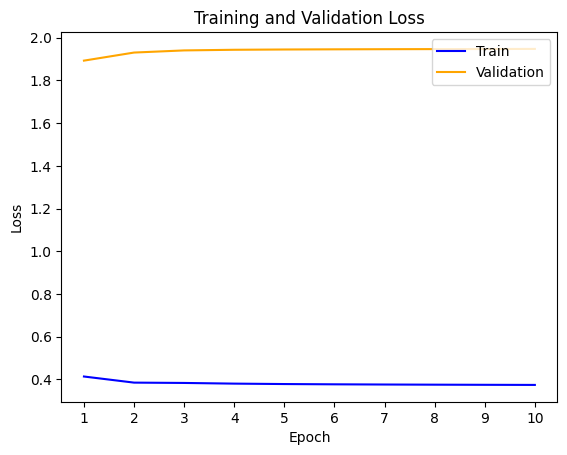

In [51]:
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# plot losses
x = list(range(1, n_epoch + 1))
plt.plot(x, train_loss_list, color="blue", label="Train")
plt.plot(x, valid_loss_list, color="orange", label="Validation")
plt.legend(loc="upper right")
plt.xticks(x)

plt.show()

#### Evaluation

In [53]:
# prepare model for evaluation
vision_transformer.eval()

test_loss = 0.0
accuracy = 0

# number of classes
n_class = len(class_names)

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

# move model back to cpu
vision_transformer = vision_transformer.to("cpu")

# test model
for images, targets in test_loader:

    # get outputs
    outputs = vision_transformer(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

        targets = targets.to("cpu")

        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print("Test Loss: {:.6f}".format(test_loss))

Test Loss: 1.838110


In [55]:
class_accuracy = class_correct / class_total

print("Test Accuracy of Classes")
print()

for c in range(n_class):
    print(
        "{}\t: {}% \t ({}/{})".format(
            class_names[c],
            int(class_accuracy[c] * 100),
            int(class_correct[c]),
            int(class_total[c]),
        )
    )

print()
print(
    "Test Accuracy of Dataset: \t {}% \t ({}/{})".format(
        int(accuracy), int(np.sum(class_correct)), int(np.sum(class_total))
    )
)

Test Accuracy of Classes

destroyed	: 0% 	 (0/183)
major-damage	: 0% 	 (0/409)
minor-damage	: 0% 	 (0/1363)
no-damage	: 100% 	 (3647/3647)
un-classified	: 0% 	 (0/55)

Test Accuracy of Dataset: 	 64% 	 (3647/5657)
